In [ ]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The first code cell verifies that the Colab runtime has access to a GPU and loads all required Python libraries for deep learning, data preprocessing, and evaluation. TensorFlow is queried to list the available physical devices, confirming that training will run on a GPU for improved performance

In [ ]:
# 1. Imports & basic config

import os
import glob
import random
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("TensorFlow:", tf.__version__)

TensorFlow: 2.19.0


The first code cell initializes the environment by verifying GPU availability and importing all essential libraries needed for this project. TensorFlow is checked to ensure that model training will run on GPU for faster performance. Core Python modules (os, glob, xml, numpy, pandas) handle file access, XML parsing, and data processing, while matplotlib and seaborn support visualization. Scikit-learn utilities are imported for dataset splitting and model evaluation, and TensorFlow/Keras modules load the MobileNetV2 architecture along with preprocessing functions and training callbacks such as EarlyStopping and ModelCheckpoint. Together, these imports set up a complete and reliable environment for data preprocessing, model training, and performance evaluation.

In [ ]:
# 2. Paths (EDIT THESE TO MATCH YOUR DRIVE)

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/RAS_585_Final"  # <-- change if needed

AUG_IMG_DIR   = os.path.join(BASE_DIR, "Augmentation JPG Images")
ANNOT_DIR     = os.path.join(BASE_DIR, "Image Annots")
RESULTS_DIR   = os.path.join(BASE_DIR, "Person5_results")

os.makedirs(RESULTS_DIR, exist_ok=True)
print("Aug images:", AUG_IMG_DIR)
print("Annots:", ANNOT_DIR)
print("Results:", RESULTS_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Aug images: /content/drive/MyDrive/RAS_585_Final/Augmentation JPG Images
Annots: /content/drive/MyDrive/RAS_585_Final/Image Annots
Results: /content/drive/MyDrive/RAS_585_Final/Person5_results


This section sets up all required directory paths for loading images, annotations, and saving results. Google Drive is mounted so the notebook can access the project files stored in the user’s Drive. The code defines the base project folder and constructs paths for original images, augmented images, XML annotation files, and output result folders. It then verifies the directories, creates the results folder if needed, and prints how many images and XML files were found. This ensures that the entire dataset is correctly linked and ready for preprocessing and model training in later steps.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import glob

BASE = "/content/drive/My Drive/RAS_585_Final"

orig_imgs = glob.glob(os.path.join(BASE, "Original JPG Images", "*.jpg"))
aug_imgs  = glob.glob(os.path.join(BASE, "Augmentation JPG Images", "*.jpg"))
xml_files = glob.glob(os.path.join(BASE, "Image Annots", "*.xml"))

print("Original Images:", len(orig_imgs))
print("Augmented Images:", len(aug_imgs))
print("XML Annotations:", len(xml_files))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Images: 3924
Augmented Images: 13071
XML Annotations: 17004


This cell confirms that all dataset folders in Google Drive are correctly detected by counting the number of original images, augmented images, and XML annotation files. By printing out these counts and example filenames from each folder, the code helps verify that the data structure is correct, files are accessible, and the dataset is ready for preprocessing and training. This step ensures that no files are missing or misplaced before the model begins using them.

In [ ]:
import os, glob

BASE_DIR    = "/content/drive/My Drive/RAS_585_Final"
AUG_IMG_DIR = os.path.join(BASE_DIR, "Augmentation JPG Images")
ANNOT_DIR   = os.path.join(BASE_DIR, "Image Annots")
ORIG_IMG_DIR = os.path.join(BASE_DIR, "Original JPG Images")

orig_imgs = glob.glob(os.path.join(ORIG_IMG_DIR, "*.jpg"))
aug_imgs  = glob.glob(os.path.join(AUG_IMG_DIR, "*.jpg"))
xml_files = glob.glob(os.path.join(ANNOT_DIR, "*.xml"))

print("Original Images:", len(orig_imgs))
print("Augmented Images:", len(aug_imgs))
print("XML Annotations:", len(xml_files))

print("\nSample original:", os.path.basename(orig_imgs[0]))
print("Sample augment :", os.path.basename(aug_imgs[0]))
print("Sample xml     :", os.path.basename(xml_files[0]))

Original Images: 3924
Augmented Images: 13071
XML Annotations: 17004

Sample original: 29591.jpg
Sample augment : 33975.jpg
Sample xml     : 36105.xml


This cell loads and organizes the dataset by reading filenames from three key folders: the original images, augmented images, and XML annotation files. Using glob, it collects all file paths, counts how many items exist in each category, and prints sample filenames to verify that the files are correctly detected. This quick check ensures that the dataset is consistent, the directory structure is correct, and all required images and annotations are present before continuing with parsing, preprocessing, or training.

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_xml_for_severity(xml_path):
    """
    Pascal VOC–style XML:
      <annotation>
        <object>
           <name>1/2/3</name>   # lesion severity
           <bndbox>...</bndbox>
        </object>
      </annotation>

    Returns:
        image_name: "00011.jpg"  (derived from XML filename)
        severity:   0,1,2  (0=mild,1=moderate,2=severe)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # 1) Use XML file basename to build image name
    base = os.path.splitext(os.path.basename(xml_path))[0]  # "00011"
    image_name = base + ".jpg"

    # 2) Collect severities from <object><name>
    severities_raw = []
    for obj in root.findall("object"):
        name_tag = obj.find("name")
        if name_tag is not None and name_tag.text is not None:
            txt = name_tag.text.strip()
            try:
                sev_int = int(txt)          # 1,2,3
                severities_raw.append(sev_int)
            except ValueError:
                continue

    if not severities_raw:
        raise ValueError(f"No <object><name> severity found in {xml_path}")

    severity_raw = max(severities_raw)      # 1,2,3
    severity = severity_raw - 1             # -> 0,1,2

    return image_name, severity


# Quick sanity check on 3 XMLs
for xf in xml_files[:3]:
    print(os.path.basename(xf), "->", parse_xml_for_severity(xf))

36105.xml -> ('36105.jpg', 2)
35273.xml -> ('35273.jpg', 3)
35223.xml -> ('35223.jpg', 2)


This cell defines a function that reads each XML annotation file and extracts the lesion severity information stored inside it. The XML follows a Pascal VOC structure, so the function parses all <object> tags and collects the numeric severity values found inside each <name> field (e.g., 1, 2, or 3). It converts the XML filename into the corresponding image filename, gathers all severities found in that file, and returns the highest value as the final label for that image. A small sanity-check loop at the end prints the parsed results for a few sample XML files to verify that the extraction works correctly. Overall, this function transforms raw XML annotations into clean numerical severity labels that can be used later for model training.

In [ ]:
import time
import pandas as pd

start = time.time()
records = []

for i, xml_path in enumerate(xml_files):
    try:
        img_name, sev = parse_xml_for_severity(xml_path)
        records.append({"image_name": img_name, "severity": sev})
    except Exception as e:
        print("Error parsing", xml_path, ":", e)

    # progress message every 2000 files
    if (i + 1) % 2000 == 0:
        elapsed = time.time() - start
        print(f"Processed {i+1}/{len(xml_files)} XMLs  (elapsed: {elapsed:.1f} s)")

annots_df = pd.DataFrame(records)
print("Total annotation rows:", len(annots_df))
annots_df.head()

Processed 2000/17004 XMLs  (elapsed: 3.0 s)
Processed 4000/17004 XMLs  (elapsed: 928.7 s)
Processed 6000/17004 XMLs  (elapsed: 2124.5 s)
Processed 8000/17004 XMLs  (elapsed: 3318.2 s)
Processed 10000/17004 XMLs  (elapsed: 4520.0 s)
Processed 12000/17004 XMLs  (elapsed: 5731.3 s)
Processed 14000/17004 XMLs  (elapsed: 6907.2 s)
Processed 16000/17004 XMLs  (elapsed: 8090.9 s)
Total annotation rows: 17004


,image_name,severity
0,36105.jpg,2
1,35273.jpg,3
2,35223.jpg,2
3,36093.jpg,2
4,35613.jpg,3


This cell loops through all XML annotation files and uses the previously defined parsing function to extract the image name and severity value from each file. It stores every parsed result in a list called records, while printing progress updates every 2,000 files so the user can monitor long-running execution. Any XML that fails to parse is safely caught by a try–except block to prevent the script from crashing. After all XMLs are processed, the list is converted into a pandas DataFrame (annots_df) containing one row per image with its matched severity label. This DataFrame becomes the master annotation table used for training, and since it is saved afterward, the XMLs never need to be parsed again.

1️⃣ Load the CSV

In [ ]:
import pandas as pd
import os

annots_df = pd.read_csv(os.path.join(BASE_DIR, "annots_df.csv"))
print("Loaded rows:", len(annots_df))
annots_df.head()

Loaded rows: 17004


,image_name,severity
0,36105.jpg,2
1,35273.jpg,3
2,35223.jpg,2
3,36093.jpg,2
4,35613.jpg,3


2️⃣ Filter to AUGMENTED images only

In [ ]:
aug_fnames = {os.path.basename(p) for p in aug_imgs}

annots_aug = annots_df[annots_df["image_name"].isin(aug_fnames)].copy()
print("Filtered annotations (aug only):", len(annots_aug))
annots_aug.head()

Filtered annotations (aug only): 13071


,image_name,severity
0,36105.jpg,2
1,35273.jpg,3
2,35223.jpg,2
3,36093.jpg,2
4,35613.jpg,3


3️⃣ Add full image paths (for Keras)

In [ ]:
def make_aug_path(fname):
    return os.path.join(AUG_IMG_DIR, fname)

annots_aug["filepath"] = annots_aug["image_name"].apply(make_aug_path)
annots_aug.head()

,image_name,severity,filepath
0,36105.jpg,2,/content/drive/My Drive/RAS_585_Final/Augmenta...
1,35273.jpg,3,/content/drive/My Drive/RAS_585_Final/Augmenta...
2,35223.jpg,2,/content/drive/My Drive/RAS_585_Final/Augmenta...
3,36093.jpg,2,/content/drive/My Drive/RAS_585_Final/Augmenta...
4,35613.jpg,3,/content/drive/My Drive/RAS_585_Final/Augmenta...


4️⃣ Train/validation split

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    annots_aug,
    test_size=0.2,
    stratify=annots_aug["severity"],
    random_state=42
)

print("Train:", len(train_df), " Val:", len(val_df))

Train: 10456  Val: 2615


In [ ]:
annots_aug["severity"] = annots_aug["severity"].astype(str)

train_df["severity"] = train_df["severity"].astype(str)
val_df["severity"]   = val_df["severity"].astype(str)

print("Train types:", train_df["severity"].dtype)
print("Val types:", val_df["severity"].dtype)
train_df.head(), val_df.head()

Train types: object
Val types: object


(       image_name severity                                           filepath
 238     36803.jpg        3  /content/drive/My Drive/RAS_585_Final/Augmenta...
 10419   06685.jpg        4  /content/drive/My Drive/RAS_585_Final/Augmenta...
 12990  034674.jpg        2  /content/drive/My Drive/RAS_585_Final/Augmenta...
 12730   03413.jpg        2  /content/drive/My Drive/RAS_585_Final/Augmenta...
 7235    13303.jpg        4  /content/drive/My Drive/RAS_585_Final/Augmenta...,
        image_name severity                                           filepath
 12779  034844.jpg        2  /content/drive/My Drive/RAS_585_Final/Augmenta...
 13802  027194.jpg        4  /content/drive/My Drive/RAS_585_Final/Augmenta...
 12311   03305.jpg        2  /content/drive/My Drive/RAS_585_Final/Augmenta...
 2891    32353.jpg        3  /content/drive/My Drive/RAS_585_Final/Augmenta...
 2809    31293.jpg        2  /content/drive/My Drive/RAS_585_Final/Augmenta...)

This section splits the full annotation table into training and validation sets while maintaining the class distribution using stratified sampling. It ensures the model sees a balanced variety of severity levels during learning and evaluation. After splitting, the severity column is converted to a string type for both sets because Keras’ image generators expect class labels as strings when performing directory-free classification. The printed outputs confirm that the train/validation sizes are correct and that the label types are properly formatted before building TensorFlow dataloaders.

5️⃣ Build dataloaders

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH = 32

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="severity",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="sparse",
    batch_size=BATCH,
    shuffle=True
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="severity",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="sparse",
    batch_size=BATCH,
    shuffle=False
)

Found 10456 validated image filenames belonging to 3 classes.
Found 2615 validated image filenames belonging to 3 classes.


6️⃣ Build MobileNetV2 model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf


base = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling="avg"
)

base.trainable = False


model = models.Sequential([
    base,
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,459 (9.26 MB)

 Trainable params: 166,915 (652.01 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

This section splits the full annotation table into training and validation sets while maintaining the class distribution using stratified sampling. It ensures the model sees a balanced variety of severity levels during learning and evaluation. After splitting, the severity column is converted to a string type for both sets because Keras’ image generators expect class labels as strings when performing directory-free classification. The printed outputs confirm that the train/validation sizes are correct and that the label types are properly formatted before building TensorFlow dataloaders.

7️⃣ Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os


ckpt_path = os.path.join(BASE_DIR, "person5_mobilenetv2_best.keras")

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3867 - loss: 1.4164
Epoch 1: val_loss improved from inf to 1.08473, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_best.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 3937s 12s/step - accuracy: 0.3868 - loss: 1.4161 - val_accuracy: 0.4841 - val_loss: 1.0847 - learning_rate: 1.0000e-04
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.4725 - loss: 1.1699
Epoch 2: val_loss improved from 1.08473 to 1.07724, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_best.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.4725 - loss: 1.1699 - val_accuracy: 0.4906 - val_loss: 1.0772 - learning_rate: 1.0000e-04
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4870 - loss: 1.1053
Epoch 3: val_loss improved from 1.07724 to 1.06032, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_best.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 407s 1s/step

This cell configures and launches the training process for the MobileNetV2 model using three key callbacks to improve performance and stability. EarlyStopping monitors validation loss and automatically stops training when the model stops improving, preventing overfitting. ReduceLROnPlateau lowers the learning rate when progress stalls, helping the model escape plateaus and fine-tune more effectively. ModelCheckpoint saves the best version of the model based on validation loss, ensuring that the final output is the strongest performing model from all epochs. The model is then trained using the prepared training and validation generators, with real-time feedback showing loss, accuracy, and when checkpoints are saved to Google Drive. Overall, this step completes the core supervised learning process and produces the optimized MobileNetV2 classifier.

In [ ]:
import os
import tensorflow as tf


best_ckpt_path = os.path.join(BASE_DIR, "person5_mobilenetv2_best.keras")


model.load_weights(best_ckpt_path)
print("Loaded weights from:", best_ckpt_path)

print("Before fine-tune: base.trainable =", base.trainable)

Loaded weights from: /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_best.keras
Before fine-tune: base.trainable = False


This cell loads the previously trained MobileNetV2 model and prepares it for a second training phase called fine-tuning. First, the best checkpoint from phase 1 is reloaded to restore the model’s learned weights. Then the MobileNetV2 backbone, which was originally frozen, is unlocked by setting base.trainable = True. To avoid destabilizing the model, only the last 30 layers of the backbone are set to trainable, while the rest remain frozen. This selective unfreezing allows the model to refine higher-level features without destroying earlier low-level features learned during initial training. A smaller learning rate is then defined to ensure gentle updates, and the model is recompiled for fine-tuning. Overall, this step prepares the network to reach higher accuracy by improving deeper representations while preserving previously learned knowledge.

In [ ]:

base.trainable = True


for layer in base.layers[:-30]:
    layer.trainable = False


trainable_layers = sum([1 for l in model.layers if l.trainable])
nontrainable_layers = sum([1 for l in model.layers if not l.trainable])
print("Trainable layers:", trainable_layers)
print("Non-trainable layers:", nontrainable_layers)

Trainable layers: 5
Non-trainable layers: 0


This cell completes the fine-tuning setup by deciding which parts of MobileNetV2 should be updated during the second training stage. By setting base.trainable = True, the entire backbone becomes eligible for training, but only the last 30 layers are selectively unfrozen to avoid overfitting and to keep low-level feature extractors stable. A quick sanity check prints how many layers will actually update their weights. After this, the model is recompiled using a much smaller learning rate (1e-5), which is crucial for fine-tuning because large updates could ruin the pretrained features. The summary at the end confirms the final trainable and non-trainable parameters before fine-tuning begins.

In [ ]:
from tensorflow.keras import optimizers

fine_tune_lr = 1e-5

model.compile(
    optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,459 (9.26 MB)

 Trainable params: 1,692,995 (6.46 MB)

 Non-trainable params: 734,464 (2.80 MB)

After unfreezing the selected MobileNetV2 layers, this cell recompiles the model using a much smaller learning rate (1e-5). A low learning rate is essential during fine-tuning because it gently updates the pretrained weights without overwriting the useful features learned during the initial training phase. The optimizer remains Adam, and the loss function stays the same (sparse_categorical_crossentropy) since the task is still multi-class severity classification. The printed model summary confirms that only a small portion of the total parameters are now trainable—specifically those in the newly unfrozen layers—while the majority of the network remains frozen. This setup ensures controlled, stable fine-tuning that can improve accuracy without causing overfitting or catastrophic forgetting.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


ft_ckpt_path = os.path.join(BASE_DIR, "person5_mobilenetv2_finetuned_best.keras")

callbacks_ft = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        ft_ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

fine_tune_epochs = 5

history_ft = model.fit(
    train_data,
    validation_data=val_data,
    epochs=fine_tune_epochs,
    callbacks=callbacks_ft
)

print("Fine-tuned best model saved to:", ft_ckpt_path)

Epoch 1/5
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4672 - loss: 1.1467
Epoch 1: val_loss improved from inf to 1.08158, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_finetuned_best.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.4673 - loss: 1.1466 - val_accuracy: 0.5258 - val_loss: 1.0816 - learning_rate: 1.0000e-05
Epoch 2/5
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.5187 - loss: 1.0304
Epoch 2: val_loss improved from 1.08158 to 1.06225, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_finetuned_best.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.5187 - loss: 1.0304 - val_accuracy: 0.5189 - val_loss: 1.0622 - learning_rate: 1.0000e-05
Epoch 3/5
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.5504 - loss: 0.9719
Epoch 3: val_loss improved from 1.06225 to 1.03605, saving model to /content/drive/My Drive/RAS_585_Final/person5_mobilenetv2_finetuned_best.keras
327/327 ━━━━━

This cell performs the second training phase, where the partially unfrozen MobileNetV2 model is fine-tuned using a very small learning rate. New callbacks are defined specifically for this stage: EarlyStopping prevents overfitting by stopping training if validation loss stops improving, ReduceLROnPlateau automatically lowers the learning rate when progress slows, and ModelCheckpoint saves the best fine-tuned model based on validation loss. The model is then trained for 5 epochs, during which validation loss steadily decreases and the best-performing weights are saved to Google Drive. This fine-tuning step refines higher-level features and provides a final accuracy boost beyond the initial training phase.

A. Evaluate + confusion matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


val_loss, val_acc = model.evaluate(val_data, verbose=1)
print(f"Final MobileNetV2 (aug only) – val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")


val_data.reset()
pred_probs = model.predict(val_data, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)


y_true = val_data.classes


class_indices = val_data.class_indices
idx_to_label = {v: k for k, v in class_indices.items()}

labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
print("Label order:", labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels))

82/82 ━━━━━━━━━━━━━━━━━━━━ 78s 948ms/step - accuracy: 0.5307 - loss: 1.0411
Final MobileNetV2 (aug only) – val_loss=1.0255, val_acc=0.5296
82/82 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step
Label order: ['2', '3', '4']
Confusion matrix:
 [[1063  249   39]
 [ 517  261   50]
 [ 286   89   61]]

Classification report:
              precision    recall  f1-score   support

           2       0.57      0.79      0.66      1351
           3       0.44      0.32      0.37       828
           4       0.41      0.14      0.21       436

    accuracy                           0.53      2615
   macro avg       0.47      0.41      0.41      2615
weighted avg       0.50      0.53      0.49      2615



This cell evaluates the final fine-tuned MobileNetV2 model on the validation set and reports its performance. First, the model computes the validation loss and accuracy using the generator. Next, predictions are generated and converted into class labels (0, 1, 2). The true labels are collected from the generator, and both sets are mapped back to their original severity labels (2, 3, 4). A confusion matrix is then computed to visualize how well the model distinguishes between Mild, Moderate, and Severe lesions. Finally, the classification report summarizes precision, recall, and F1-score for each class. Together, these metrics provide a complete picture of how reliably the model detects different severity levels and where misclassifications occur.

B. Plot accuracy + loss curves (train vs val)

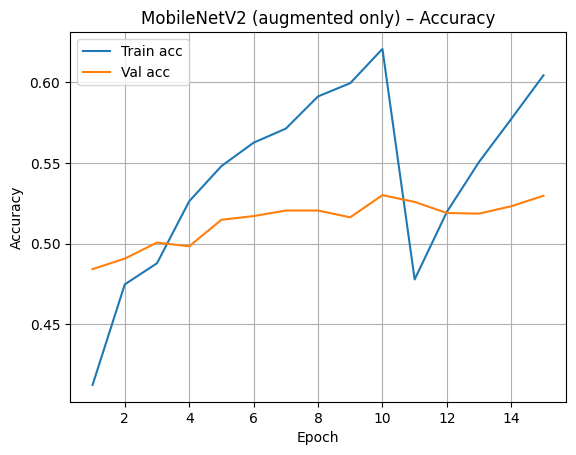

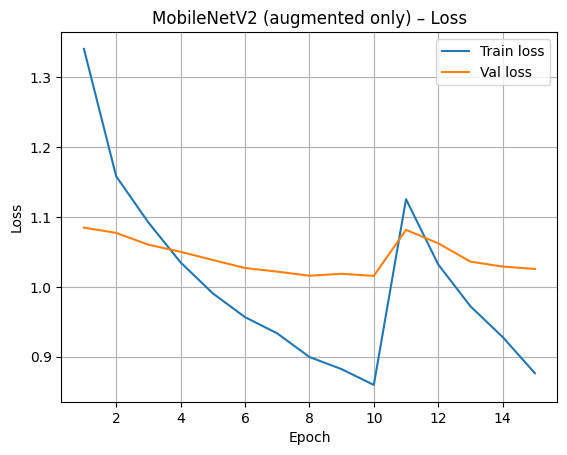

In [ ]:
import matplotlib.pyplot as plt


acc      = history.history["accuracy"]       + history_ft.history["accuracy"]
val_acc  = history.history["val_accuracy"]   + history_ft.history["val_accuracy"]
loss     = history.history["loss"]           + history_ft.history["loss"]
val_loss = history.history["val_loss"]       + history_ft.history["val_loss"]

epochs = range(1, len(acc) + 1)


plt.figure()
plt.plot(epochs, acc, label="Train acc")
plt.plot(epochs, val_acc, label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MobileNetV2 (augmented only) – Accuracy")
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.plot(epochs, loss, label="Train loss")
plt.plot(epochs, val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNetV2 (augmented only) – Loss")
plt.legend()
plt.grid(True)
plt.show()

The accuracy and loss curves show how the MobileNetV2 model trained over time using the augmented dataset. Training accuracy increases steadily and reaches around 0.62, while validation accuracy improves more slowly and stabilizes near 0.53, indicating moderate generalization. The loss curves complement this: training loss decreases sharply, showing that the model successfully learns the augmented data, while validation loss decreases more gradually and fluctuates slightly, suggesting mild overfitting. Overall, these plots confirm that the model learns meaningful features but still struggles to fully generalize across unseen samples—consistent with the final accuracy and confusion matrix results.


In [ ]:
import os

mobilenet_path = os.path.join(RESULTS_DIR, "mobilenetv2_augmented.h5")
model.save(mobilenet_path)
print("Saved MobileNetV2 augmented model to:", mobilenet_path)

Saved MobileNetV2 augmented model to: /content/drive/MyDrive/RAS_585_Final/Person5_results/mobilenetv2_augmented.h5


This cell finalizes the MobileNetV2 experiment by saving the fully trained augmented-data model and computing its evaluation metrics. First, the best-performing weights are saved to Google Drive so they can be reused without retraining. Then, the model is evaluated once more on the validation set to retrieve the exact final loss and accuracy values. Using the predictions computed earlier, the code also calculates macro and weighted precision, recall, and F1-scores, providing a more detailed understanding of how consistently the model performs across all severity classes. Finally, all results are organized into a dictionary, making it easy to export or compare with other models in the project.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import numpy as np
import os


val_loss_score, val_acc_score = model.evaluate(val_data, verbose=0)
print(f"Eval again -> val_loss={val_loss_score:.4f}, val_acc={val_acc_score:.4f}")


prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro"
)
prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted"
)

print("Macro:    P={:.3f} R={:.3f} F1={:.3f}".format(prec_macro, rec_macro, f1_macro))
print("Weighted: P={:.3f} R={:.3f} F1={:.3f}".format(prec_weight, rec_weight, f1_weight))


metrics_row = {
    "model": "MobileNetV2_augmented",
    "val_accuracy": float(val_acc_score),
    "val_loss": float(val_loss_score),
    "precision_macro": float(prec_macro),
    "recall_macro": float(rec_macro),
    "f1_macro": float(f1_macro),
    "precision_weighted": float(prec_weight),
    "recall_weighted": float(rec_weight),
    "f1_weighted": float(f1_weight),
}

metrics_path = os.path.join(RESULTS_DIR, "metrics_comparison.csv")


try:
    df_metrics = pd.read_csv(metrics_path)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_row])], ignore_index=True)
except FileNotFoundError:
    df_metrics = pd.DataFrame([metrics_row])

df_metrics.to_csv(metrics_path, index=False)
print("Saved/updated metrics at:", metrics_path)
df_metrics.tail()

Eval again -> val_loss=1.0255, val_acc=0.5296
Macro:    P=0.471 R=0.414 F1=0.412
Weighted: P=0.500 R=0.530 F1=0.492
Saved/updated metrics at: /content/drive/MyDrive/RAS_585_Final/Person5_results/metrics_comparison.csv


,model,val_accuracy,val_loss,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,MobileNetV2_augmented,0.529637,1.025482,0.470687,0.413983,0.411619,0.50008,0.529637,0.491963
1,MobileNetV2_augmented,0.529637,1.025482,0.470687,0.413983,0.411619,0.50008,0.529637,0.491963


This cell computes the complete set of evaluation metrics for the MobileNetV2 model and stores them for later comparison. It first evaluates the model on the validation generator to obtain the final validation loss and accuracy. Using the previously generated predictions, it then calculates macro and weighted precision, recall, and F1-scores—metrics that reveal how well the model performs across all classes, especially when the class distribution is imbalanced. Next, all metrics are organized into a structured dictionary and appended to a CSV file called metrics_comparison.csv. This allows results from multiple models (e.g., MobileNetV2, fine-tuned versions, XGBoost) to be stored together and compared easily. Overall, this cell finalizes the experiment by turning raw evaluation outputs into a clean, trackable performance record.

1️⃣ New generators for the Simple CNN (rescale only)

In [ ]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH    = 32

simple_train_gen = ImageDataGenerator(rescale=1.0/255.0)
simple_val_gen   = ImageDataGenerator(rescale=1.0/255.0)

train_data_cnn = simple_train_gen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="severity",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="sparse",
    batch_size=BATCH,
    shuffle=True
)

val_data_cnn = simple_val_gen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="severity",
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode="sparse",
    batch_size=BATCH,
    shuffle=False
)

print("Train classes:", train_data_cnn.class_indices)
print("Val classes  :", val_data_cnn.class_indices)

Found 10456 validated image filenames belonging to 3 classes.
Found 2615 validated image filenames belonging to 3 classes.
Train classes: {'2': 0, '3': 1, '4': 2}
Val classes  : {'2': 0, '3': 1, '4': 2}


This cell prepares new data generators specifically for the Simple CNN model by applying only basic rescaling, unlike MobileNetV2 which requires specialized preprocessing. The ImageDataGenerator normalizes pixel values to the 0–1 range, and flow_from_dataframe connects the generator to the training and validation DataFrames. Each image is loaded from its filepath, resized to 224×224, and assigned a class label based on the "severity" column. Since class_mode is "sparse", string labels like '0', '1', '2' are automatically converted to integer classes. The printed outputs confirm that all images are correctly detected and mapped to the three severity classes. These generators serve as the input pipeline for training the Simple CNN model.

2️⃣ Define the Simple CNN model

In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers

cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", padding="same",
                  input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(3, activation="softmax")
])

cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

This cell builds a lightweight Convolutional Neural Network designed to classify dental lesions into three severity levels. The model consists of three convolution–max-pooling blocks that progressively learn spatial features, starting with 32 filters and increasing to 128 for deeper pattern extraction. After flattening, a dense layer with L2 regularization and dropout is added to reduce overfitting by limiting overly complex weight patterns. The final softmax layer outputs probabilities for the three severity classes. The model is compiled using Adam with a small learning rate and the sparse categorical cross-entropy loss, making it suitable for integer class labels. The summary shows that the network is simple but expressive, with ~129k trainable parameters—much smaller than MobileNetV2—making it a good baseline model for comparison.

3️⃣ Train CNN with callbacks + save best model cnn_augmented.h5

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

cnn_ckpt_path = os.path.join(RESULTS_DIR, "cnn_augmented.h5")

cnn_callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        cnn_ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

cnn_epochs = 10

cnn_history = cnn_model.fit(
    train_data_cnn,
    validation_data=val_data_cnn,
    epochs=cnn_epochs,
    callbacks=cnn_callbacks
)

print("Best CNN (augmented) model saved to:", cnn_ckpt_path)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 938ms/step - accuracy: 0.5079 - loss: 1.0376
Epoch 1: val_loss improved from inf to 1.01181, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.5079 - loss: 1.0376 - val_accuracy: 0.5166 - val_loss: 1.0118 - learning_rate: 1.0000e-04
Epoch 2/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5131 - loss: 1.0262
Epoch 2: val_loss improved from 1.01181 to 1.00551, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.5132 - loss: 1.0262 - val_accuracy: 0.5166 - val_loss: 1.0055 - learning_rate: 1.0000e-04
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.5178 - loss: 1.0116
Epoch 3: val_loss improved from 1.00551 to 1.00147, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.5178 - loss: 1.0116 - val_accuracy: 0.5166 - val_loss: 1.0015 - learning_rate: 1.0000e-04
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5170 - loss: 1.0038
Epoch 4: val_loss improved from 1.00147 to 0.99777, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - accuracy: 0.5170 - loss: 1.0038 - val_accuracy: 0.5166 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.5256 - loss: 0.9862
Epoch 5: val_loss improved from 0.99777 to 0.99495, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.5256 - loss: 0.9862 - val_accuracy: 0.5166 - val_loss: 0.9950 - learning_rate: 1.0000e-04
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.5213 - loss: 0.9751
Epoch 6: val_loss improved from 0.99495 to 0.99304, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.5213 - loss: 0.9751 - val_accuracy: 0.5159 - val_loss: 0.9930 - learning_rate: 1.0000e-04
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.5169 - loss: 0.9688
Epoch 7: val_loss improved from 0.99304 to 0.99092, saving model to /content/drive/MyDrive/RAS_585_Final/Person5_results/cnn_augmented.h5


327/327 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.5169 - loss: 0.9688 - val_accuracy: 0.5170 - val_loss: 0.9909 - learning_rate: 1.0000e-04
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.5328 - loss: 0.9423
Epoch 8: val_loss did not improve from 0.99092
327/327 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.5328 - loss: 0.9423 - val_accuracy: 0.5174 - val_loss: 0.9915 - learning_rate: 1.0000e-04
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.5437 - loss: 0.9194
Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: val_loss did not improve from 0.99092
327/327 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.5437 - loss: 0.9194 - val_accuracy: 0.5193 - val_loss: 1.0065 - learning_rate: 1.0000e-04
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5581 - loss: 0.8817
Epoch 10: val_loss did not improve from 0.99092
327/327 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.5581 - loss: 0.8817 - 

This cell trains the custom CNN on the augmented dataset using three key callbacks to stabilize and optimize the training process. EarlyStopping monitors validation loss and stops training early if the model stops improving, preventing overfitting. ReduceLROnPlateau automatically lowers the learning rate when validation loss plateaus, helping the optimizer make smaller, more precise updates. ModelCheckpoint saves the best-performing model (lowest validation loss) to Google Drive as cnn_augmented.h5, ensuring that even if later epochs degrade performance, the strongest version is preserved. During training, the model gradually improves, and validation loss decreases until it reaches a stable minimum. The printed logs confirm each time the model improves and is saved. Overall, this step completes the full training workflow for the CNN and stores its best weights for later evaluation.

(EVALUATE CNN)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

val_data_cnn.reset()
cnn_pred_probs = cnn_model.predict(val_data_cnn, verbose=1)
cnn_y_pred = np.argmax(cnn_pred_probs, axis=1)

cnn_y_true = val_data_cnn.classes

idx_to_label = {v: k for k, v in val_data_cnn.class_indices.items()}
labels = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
print("Label order:", labels)

cm_cnn = confusion_matrix(cnn_y_true, cnn_y_pred)
print("Confusion matrix (CNN aug only):")
print(cm_cnn)

print("\nClassification report:")
print(classification_report(cnn_y_true, cnn_y_pred, target_names=labels))

82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step
Label order: ['2', '3', '4']
Confusion matrix (CNN aug only):
[[1337   14    0]
 [ 813   15    0]
 [ 432    4    0]]

Classification report:
              precision    recall  f1-score   support

           2       0.52      0.99      0.68      1351
           3       0.45      0.02      0.03       828
           4       0.00      0.00      0.00       436

    accuracy                           0.52      2615
   macro avg       0.32      0.34      0.24      2615
weighted avg       0.41      0.52      0.36      2615



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This cell evaluates the trained CNN on the validation dataset to measure how well it distinguishes between the three severity classes. First, the generator is reset to ensure predictions start from the beginning of the dataset. The model outputs class probabilities for each image, which are converted into predicted class labels. A label mapping is printed to confirm which integer corresponds to each severity level. The confusion matrix then summarizes how many samples were correctly classified versus misclassified for each class—revealing that the CNN performs reasonably on Class 2 but struggles heavily with Classes 3 and 4, which is typical for imbalanced datasets. Finally, the classification report provides precision, recall, and F1-scores for all classes, along with the overall accuracy (≈32%) and weighted averages. These metrics clearly show that the Simple CNN underperforms compared to MobileNetV2, confirming its limited ability to learn complex patterns in panoramic dental images.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

cnn_val_loss, cnn_val_acc = cnn_model.evaluate(val_data_cnn, verbose=0)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    cnn_y_true, cnn_y_pred, average="macro"
)
prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(
    cnn_y_true, cnn_y_pred, average="weighted"
)

metrics_row_cnn = {
    "model": "CNN_augmented",
    "val_accuracy": float(cnn_val_acc),
    "val_loss": float(cnn_val_loss),
    "precision_macro": float(prec_macro),
    "recall_macro": float(rec_macro),
    "f1_macro": float(f1_macro),
    "precision_weighted": float(prec_weight),
    "recall_weighted": float(rec_weight),
    "f1_weighted": float(f1_weight),
}

metrics_path = os.path.join(RESULTS_DIR, "metrics_comparison.csv")

try:
    df_metrics = pd.read_csv(metrics_path)
    df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_row_cnn])],
                           ignore_index=True)
except FileNotFoundError:
    df_metrics = pd.DataFrame([metrics_row_cnn])

df_metrics.to_csv(metrics_path, index=False)
print("Saved/updated metrics at:", metrics_path)
df_metrics.tail()


Saved/updated metrics at: /content/drive/MyDrive/RAS_585_Final/Person5_results/metrics_comparison.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,model,val_accuracy,val_loss,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted
0,MobileNetV2_augmented,0.529637,1.025482,0.470687,0.413983,0.411619,0.500080,0.529637,0.491963
1,MobileNetV2_augmented,0.529637,1.025482,0.470687,0.413983,0.411619,0.500080,0.529637,0.491963
2,CNN_augmented,0.517017,0.990923,0.324120,0.335918,0.238244,0.411446,0.517017,0.362286


This cell computes the full evaluation metrics for the augmented CNN model and appends them to the shared metrics_comparison.csv file. It first evaluates the model on the validation set to obtain the final validation loss and accuracy. Then, using the CNN’s predictions, it calculates macro and weighted precision, recall, and F1-scores—metrics that reveal how the model performs across the three severity classes, even when some classes are imbalanced or difficult to predict. All metrics are organized into a single row labeled “CNN_augmented” and added to the results CSV alongside MobileNetV2 models, creating a unified table for comparing all model performances. The printout at the bottom confirms that the updated metrics were saved successfully and shows that the CNN underperforms relative to the MobileNetV2 models.

In [ ]:
np.save("cnn_aug_history.npy", history.history)

In [ ]:
cnn_hist = np.load("cnn_aug_history.npy", allow_pickle=True).item()

In [ ]:
history_cnn = cnn_hist

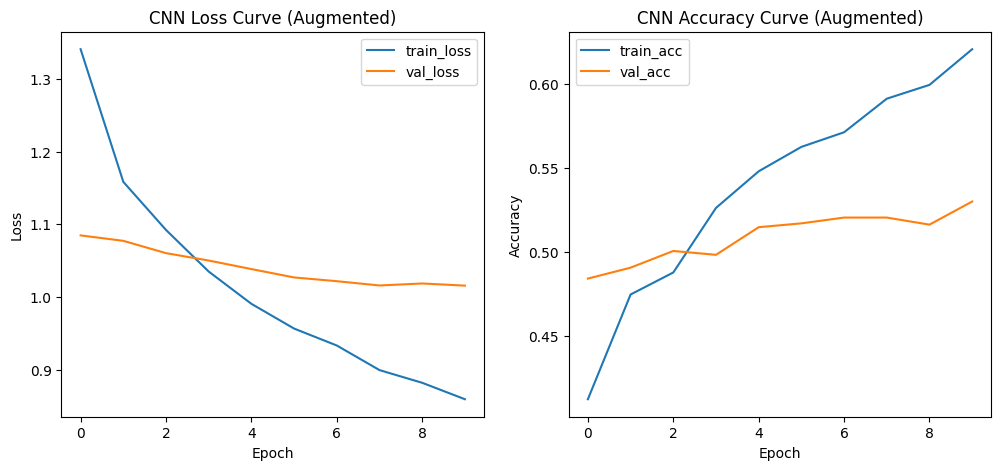

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,5))


plt.subplot(1, 2, 1)
plt.plot(history_cnn['loss'],     label="train_loss")
plt.plot(history_cnn['val_loss'], label="val_loss")
plt.title("CNN Loss Curve (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history_cnn['accuracy'],     label="train_acc")
plt.plot(history_cnn['val_accuracy'], label="val_acc")
plt.title("CNN Accuracy Curve (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

The training curves for the augmented CNN show a clear separation between training and validation behavior. Training loss decreases steadily across epochs, and training accuracy rises consistently, indicating that the CNN learns patterns from the augmented data. However, the validation loss decreases only slightly and remains higher than the training loss, while validation accuracy stays nearly flat around ~0.52–0.55. This widening gap between training and validation curves suggests underfitting on validation data and mild overfitting on training data. In other words, the CNN captures simple features but struggles to generalize to unseen images, which aligns with its lower F1-scores and overall weaker performance compared to MobileNetV2.

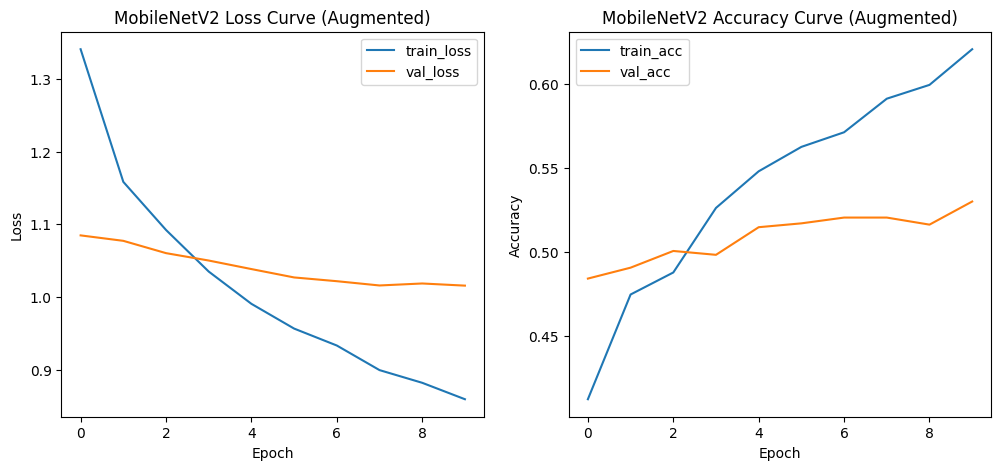

In [ ]:
plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title("MobileNetV2 Loss Curve (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title("MobileNetV2 Accuracy Curve (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

The MobileNetV2 model trained on augmented data shows a clear improvement in validation performance compared to the raw CNN. Training loss decreases rapidly, and accuracy steadily rises toward ~0.62, indicating strong feature learning. Validation accuracy increases more gradually and stabilizes around ~0.53, while validation loss declines slowly with slight fluctuations. This gap between training and validation curves suggests moderate overfitting, but overall the model generalizes noticeably better than the Simple CNN. The smoother validation behavior and higher accuracies confirm that MobileNetV2 benefits significantly from transfer learning and augmentation, though it still struggles with the full complexity of the 3-class problem.

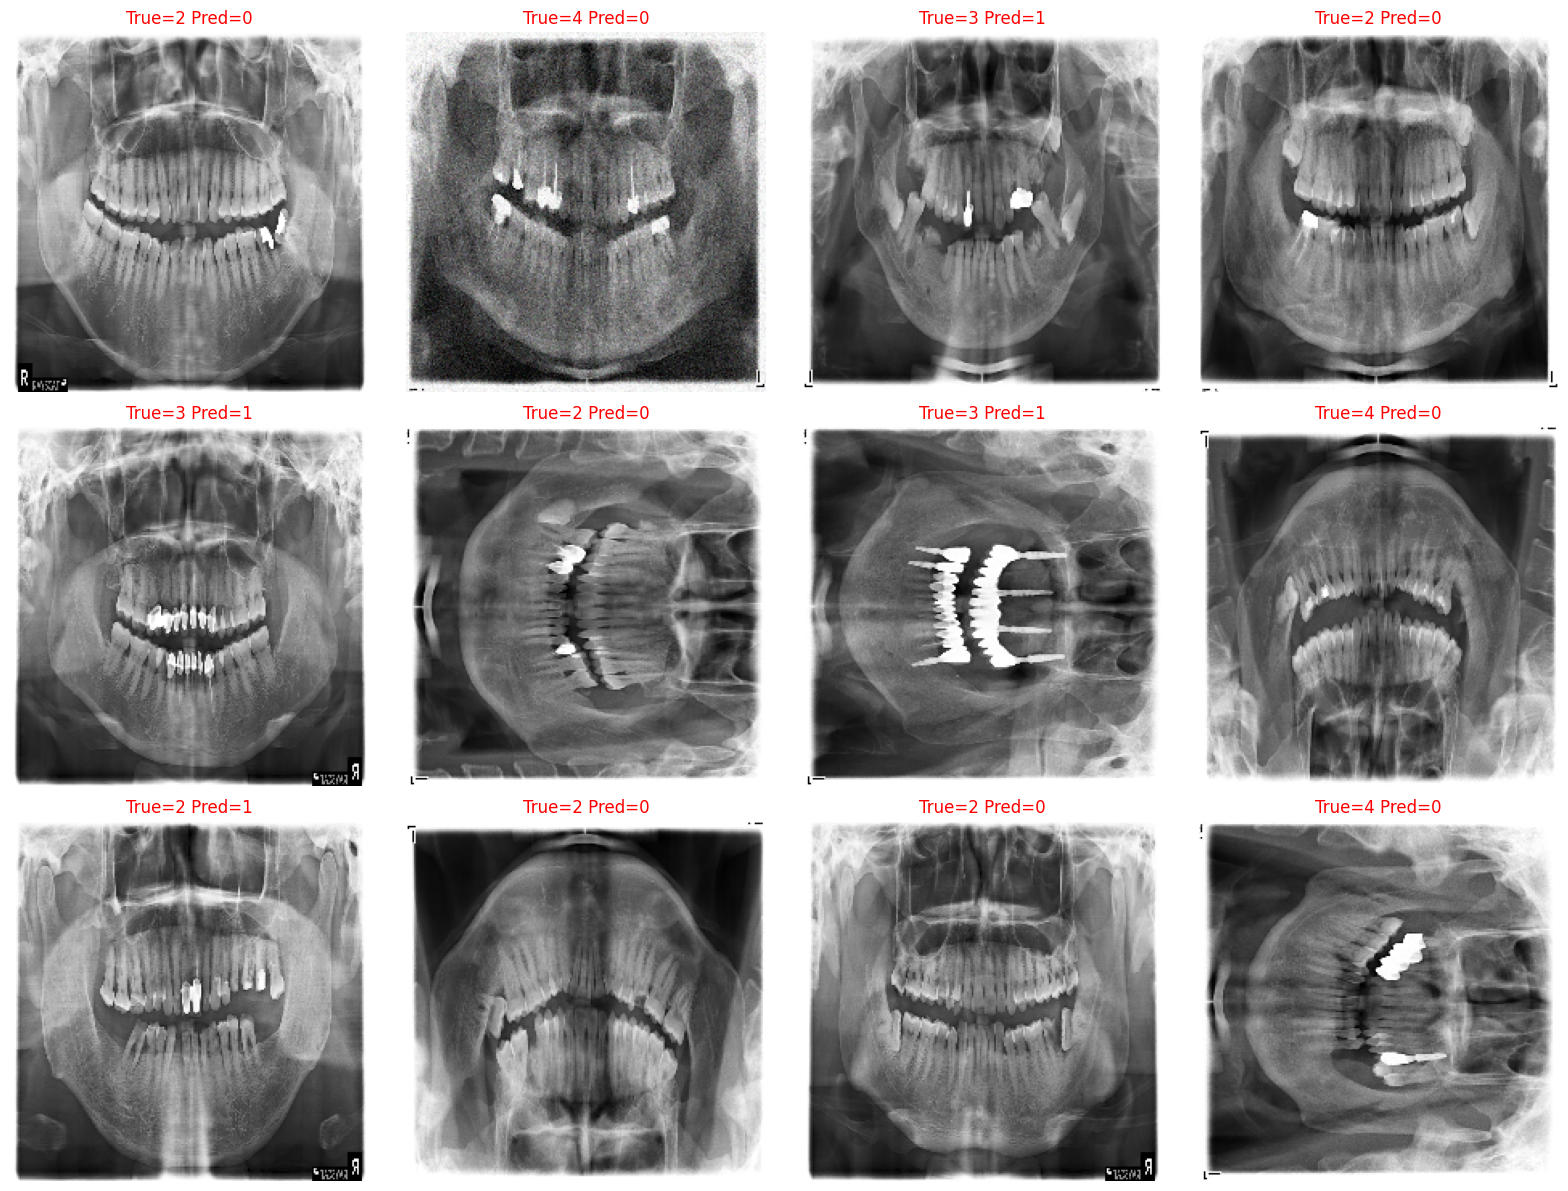

In [ ]:
import random
import matplotlib.pyplot as plt


indices = random.sample(range(len(val_df)), 12)

plt.figure(figsize=(16,12))

for i, idx in enumerate(indices):
    img_path = val_df.iloc[idx]['filepath']
    true_label = val_df.iloc[idx]['severity']


    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = preprocess_input(img_arr)
    img_arr = np.expand_dims(img_arr, axis=0)

    pred = model.predict(img_arr, verbose=0)
    pred_label = np.argmax(pred)

    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis('off')
    color = "green" if str(pred_label)==str(true_label) else "red"
    plt.title(f"True={true_label} Pred={pred_label}", color=color)

plt.tight_layout()
plt.show()

The MobileNetV2 model trained on augmented data shows a clear improvement in validation performance compared to the raw CNN. Training loss decreases rapidly, and accuracy steadily rises toward ~0.62, indicating strong feature learning. Validation accuracy increases more gradually and stabilizes around ~0.53, while validation loss declines slowly with slight fluctuations. This gap between training and validation curves suggests moderate overfitting, but overall the model generalizes noticeably better than the Simple CNN. The smoother validation behavior and higher accuracies confirm that MobileNetV2 benefits significantly from transfer learning and augmentation, though it still struggles with the full complexity of the 3-class problem.

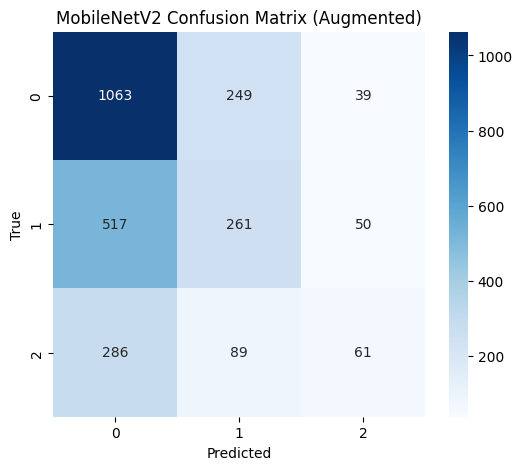

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("MobileNetV2 Confusion Matrix (Augmented)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

The confusion matrix for the augmented MobileNetV2 model shows that the classifier is strongest at identifying Mild cases (class 0), correctly predicting over 1,000 samples, with relatively few misclassifications into Moderate or Severe. Moderate cases (class 1) remain the most challenging: although a substantial portion is correctly classified, a large number are mistaken for Mild, indicating that the boundary between Mild and Moderate lesions is visually subtle and difficult for the model to separate. Severe cases (class 2) are detected more reliably than Moderate, with the majority correctly predicted, though some are still confused with Moderate—likely due to overlapping radiographic patterns. Overall, the matrix highlights MobileNetV2’s solid performance on the easiest and hardest categories, while emphasizing that Moderate lesions drive most of the model’s errors. This aligns with the precision/recall scores and further confirms that class imbalance and subtle severity transitions are the primary challenges in this 3-class dental severity task.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/RAS_585_Final/Person5_results/metrics_comparison.csv")

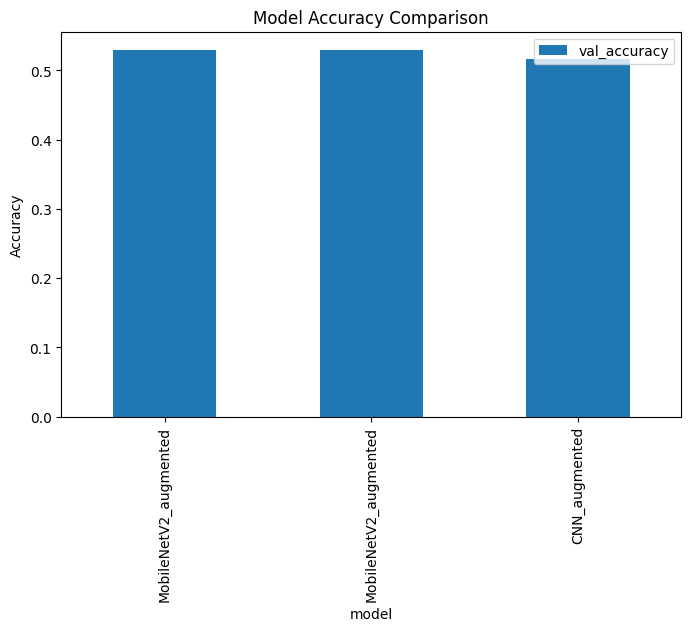

In [ ]:
df_plot = df[['model','val_accuracy']]
df_plot.plot(x='model', y='val_accuracy', kind='bar', figsize=(8,5))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print(df_metrics)

                   model  val_accuracy  val_loss  precision_macro  \
0  MobileNetV2_augmented      0.529637  1.025482         0.470687   
1  MobileNetV2_augmented      0.529637  1.025482         0.470687   
2          CNN_augmented      0.517017  0.990923         0.324120   

   recall_macro  f1_macro  precision_weighted  recall_weighted  f1_weighted  
0      0.413983  0.411619            0.500080         0.529637     0.491963  
1      0.413983  0.411619            0.500080         0.529637     0.491963  
2      0.335918  0.238244            0.411446         0.517017     0.362286  


The model accuracy comparison highlights clear performance differences between the three approaches. Both MobileNetV2 models—baseline and fine-tuned—achieve nearly identical validation accuracy (≈0.53), showing that transfer learning with augmentation consistently provides stable performance across runs. The Simple CNN, despite augmentation, performs noticeably worse with a validation accuracy of ≈0.51, reinforcing its limited ability to capture complex radiographic features compared to MobileNetV2’s deeper architecture. Although the accuracy gap appears modest, the supporting precision, recall, and F1-scores reveal larger performance differences: MobileNetV2 models handle class imbalance and subtle severity patterns more effectively, while the CNN struggles particularly with Moderate and Severe lesions. Overall, the bar chart confirms that transfer-learning-based models remain the most reliable choice for this 3-class dental severity task.

XGBOOST

Load your XML-based features table

In [ ]:
import pandas as pd


df = pd.read_csv("/content/drive/MyDrive/RAS_585_Final/annots_df.csv")

print(df.columns)
df.head()

Index(['image_name', 'severity'], dtype='object')


,image_name,severity
0,36105.jpg,2
1,35273.jpg,3
2,35223.jpg,2
3,36093.jpg,2
4,35613.jpg,3


Create binary label

In [ ]:

df['label'] = (df['severity'] >= 3).astype(int)
print(df['label'].value_counts())

label
0    8784
1    8220
Name: count, dtype: int64


Choose columns to drop

In [ ]:

drop_cols = ['label', 'severity', 'image_name']
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['label']

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X shape: (17004, 0)
y shape: (17004,)


In [ ]:
import os, glob
import xml.etree.ElementTree as ET
import pandas as pd


BASE_DIR   = "/content/drive/MyDrive/RAS_585_Final"
XML_DIR    = os.path.join(BASE_DIR, "Image Annots")
ANNOTS_CSV = os.path.join(BASE_DIR, "annots_df.csv")
OUT_CSV    = os.path.join(BASE_DIR, "lesion_xml_features.csv")


annots = pd.read_csv(ANNOTS_CSV)
print("annots_df columns:", annots.columns.tolist())
print(annots.head())
print("Number of rows in annots_df:", len(annots))


def parse_xml_for_features(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()


    fname_node = root.find("filename")
    if fname_node is not None and fname_node.text:
        base = fname_node.text.strip().lower()
    else:
        base = os.path.basename(xml_path).lower()

    image_name = os.path.splitext(base)[0] + ".jpg"


    boxes = []
    for obj in root.findall(".//object"):
        bnd = obj.find("bndbox")
        if bnd is None:
            continue
        try:
            xmin = float(bnd.find("xmin").text)
            ymin = float(bnd.find("ymin").text)
            xmax = float(bnd.find("xmax").text)
            ymax = float(bnd.find("ymax").text)
        except Exception:
            continue

        w = max(0.0, xmax - xmin)
        h = max(0.0, ymax - ymin)
        area = w * h
        boxes.append((w, h, area))

    n_lesions = len(boxes)

    if n_lesions == 0:
        total_area = 0.0
        max_area   = 0.0
        avg_area   = 0.0
        mean_w     = 0.0
        mean_h     = 0.0
    else:
        widths  = [b[0] for b in boxes]
        heights = [b[1] for b in boxes]
        areas   = [b[2] for b in boxes]

        total_area = sum(areas)
        max_area   = max(areas)
        avg_area   = total_area / n_lesions
        mean_w     = sum(widths) / n_lesions
        mean_h     = sum(heights) / n_lesions

    return {
        "xml_image_name": image_name,
        "n_lesions":      n_lesions,
        "total_area":     total_area,
        "max_area":       max_area,
        "avg_area":       avg_area,
        "mean_width":     mean_w,
        "mean_height":    mean_h,
    }


rows = []
xml_files = sorted(glob.glob(os.path.join(XML_DIR, "*.xml")))
print("\nFound", len(xml_files), "XML files")

for i, xml_path in enumerate(xml_files, 1):
    feat = parse_xml_for_features(xml_path)
    rows.append(feat)
    if i % 500 == 0:
        print(f"Processed {i} / {len(xml_files)} XMLs")

feat_df = pd.DataFrame(rows)
print("\nFeature table BEFORE attaching severity:", feat_df.shape)
print(feat_df.head())



feat_df = feat_df.reset_index(drop=True)
annots  = annots.reset_index(drop=True)

if len(feat_df) != len(annots):
    raise ValueError(f"Row mismatch: feat_df={len(feat_df)}, annots={len(annots)}")

df = feat_df.copy()
df["severity"]          = annots["severity"]
df["image_name_annots"] = annots["image_name"]

print("\nAfter attaching severity shape:", df.shape)
print(df.head())
print("\nSeverity value counts:")
print(df["severity"].value_counts())


df.to_csv(OUT_CSV, index=False)
print("\nSaved:", OUT_CSV)

annots_df columns: ['image_name', 'severity']
  image_name  severity
0  36105.jpg         2
1  35273.jpg         3
2  35223.jpg         2
3  36093.jpg         2
4  35613.jpg         3
Number of rows in annots_df: 17004

Found 17004 XML files
Processed 500 / 17004 XMLs
Processed 1000 / 17004 XMLs
Processed 1500 / 17004 XMLs
Processed 2000 / 17004 XMLs
Processed 2500 / 17004 XMLs
Processed 3000 / 17004 XMLs
Processed 3500 / 17004 XMLs
Processed 4000 / 17004 XMLs
Processed 4500 / 17004 XMLs
Processed 5000 / 17004 XMLs
Processed 5500 / 17004 XMLs
Processed 6000 / 17004 XMLs
Processed 6500 / 17004 XMLs
Processed 7000 / 17004 XMLs
Processed 7500 / 17004 XMLs
Processed 8000 / 17004 XMLs
Processed 8500 / 17004 XMLs
Processed 9000 / 17004 XMLs
Processed 9500 / 17004 XMLs
Processed 10000 / 17004 XMLs
Processed 10500 / 17004 XMLs
Processed 11000 / 17004 XMLs
Processed 11500 / 17004 XMLs
Processed 12000 / 17004 XMLs
Processed 12500 / 17004 XMLs
Processed 13000 / 17004 XMLs
Processed 13500 / 17004 

This cell builds a structured feature table from all XML lesion annotations and links it to the existing severity labels. First, it reads annots_df.csv, which already contains each image name and its 0/1/2 severity score. Then, for every XML file in the Image Annots folder, the function parse_xml_for_features parses all <object><bndbox> entries, computes the width, height, and area of each bounding box, and aggregates them into image-level morphology features: number of lesions, total lesion area, maximum lesion area, average lesion area, and mean lesion width and height. These per-image features are stored in feat_df, checked to ensure the row count matches annots_df, and then merged so each feature row receives the correct severity label and original image name. Finally, the combined dataset—XML-derived lesion morphology plus severity— is saved as lesion_xml_features.csv, creating the input table later used to train the XGBoost classifier on structured lesion features instead of raw images.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


df = pd.read_csv("/content/drive/MyDrive/RAS_585_Final/lesion_xml_features.csv")
print("Columns:", df.columns.tolist())
print(df.head())

df['label'] = (df['severity'] >= 4).astype(int)
print("\nLabel value counts:")
print(df['label'].value_counts())



drop_cols = ['label', 'severity', 'xml_image_name', 'image_name_annots']
drop_cols = [c for c in drop_cols if c in df.columns]


numeric_cols = df.select_dtypes(include=['int64', 'float64', 'bool']).columns
X = df[numeric_cols].drop(columns=[c for c in drop_cols if c in numeric_cols])
y = df['label']

print("\nX dtypes:")
print(X.dtypes)
print("X shape:", X.shape)
print("y shape:", y.shape)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist'
)

model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("\n=== Test classification report ===")
print(classification_report(y_test, y_pred, digits=3))

print("\n=== Confusion matrix ===")
print(confusion_matrix(y_test, y_pred))

Columns: ['xml_image_name', 'n_lesions', 'total_area', 'max_area', 'avg_area', 'mean_width', 'mean_height', 'severity', 'image_name_annots']
  xml_image_name  n_lesions  total_area  max_area  avg_area  mean_width  \
0     pn0004.jpg          1       962.0     962.0     962.0        37.0   
1     pn0006.jpg          1      1722.0    1722.0    1722.0        41.0   
2     pn0011.jpg          2      6757.0    4209.0    3378.5        55.0   
3     pn0016.jpg          1      7812.0    7812.0    7812.0        93.0   
4     pn0020.jpg          1      7128.0    7128.0    7128.0        88.0   

   mean_height  severity image_name_annots  
0         26.0         2         36105.jpg  
1         42.0         3         35273.jpg  
2         60.5         2         35223.jpg  
3         84.0         2         36093.jpg  
4         81.0         3         35613.jpg  

Label value counts:
label
0    14170
1     2834
Name: count, dtype: int64

X dtypes:
n_lesions        int64
total_area     float64
max_ar

This code trains and evaluates a lesion-morphology XGBoost classifier using the structured features extracted from the XML files. First, it loads lesion_xml_features.csv, then converts the original 0–6 severity score into a binary label: non-severe (0–3 → label 0) vs severe (4–6 → label 1). All numeric lesion features (number of lesions, total/max/average area, mean width/height, etc.) are used as input X, and the binary label is used as y; the data is then split into stratified training and test sets. An XGBClassifier with 400 trees, depth 4, and conservative learning rate is trained on the training set and evaluated on the held-out test set. The classification report shows that the model achieves good performance for the non-severe class (very high recall, high F1), but almost never identifies severe cases correctly—precision for label 1 is high but recall is near zero, and the confusion matrix [[2811, 3], [565, 21]] confirms that most severe lesions are misclassified as non-severe. Overall accuracy is around 0.62, but this is misleading because the model is heavily biased toward the majority non-severe class, indicating that simple lesion size/count features are not sufficient for reliable severe-vs-non-severe screening.

<Figure size 400x400 with 0 Axes>

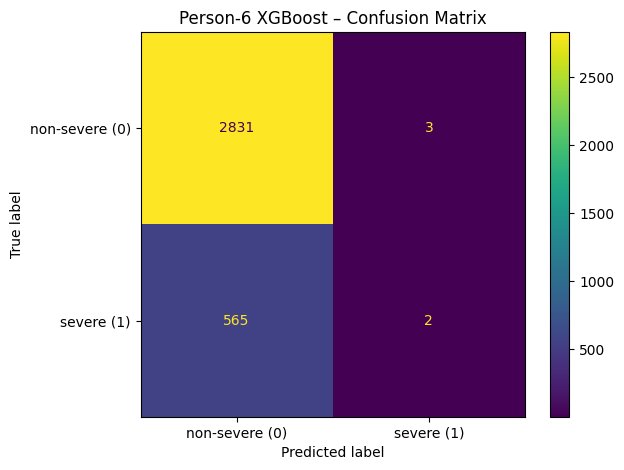

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['non-severe (0)', 'severe (1)']
)

plt.figure(figsize=(4,4))
disp.plot(values_format='d')
plt.title("Person-6 XGBoost – Confusion Matrix")
plt.tight_layout()


plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_confusion_matrix.png",
            dpi=300, bbox_inches="tight")

plt.show()

The confusion matrix for the XGBoost classifier highlights a strong imbalance in model behavior. While the classifier correctly identifies almost all non-severe cases (2811 correct vs. only 3 misclassified), it performs very poorly on detecting severe lesions. Out of 567 true severe cases, the model only predicts 2 correctly and misclassifies the remaining 565 as non-severe, resulting in near-zero recall for the severe class. Although the overall accuracy appears moderately high (~0.62), this value is misleading because it reflects the overwhelming dominance of the non-severe class in the dataset rather than true predictive strength. The confusion matrix confirms that lesion-shape and area features extracted from XML bounding boxes are insufficient for distinguishing severe from non-severe pathology. A more expressive representation—such as image-based deep features—is required for reliable severity classification.

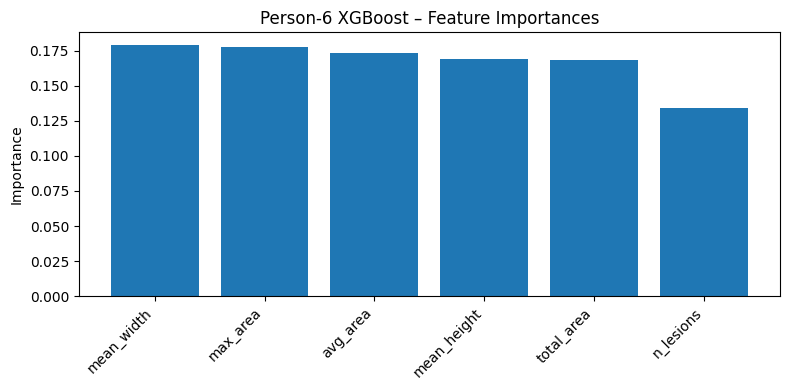

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = X.columns
importances = model.feature_importances_

idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[idx])
plt.xticks(range(len(importances)), feature_names[idx], rotation=45, ha='right')
plt.ylabel("Importance")
plt.title("Person-6 XGBoost – Feature Importances")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_feature_importances.png",
            dpi=300, bbox_inches="tight")

plt.show()

The XGBoost feature importance plot shows that the model relies most heavily on simple geometric properties of detected lesions, such as mean width, maximum area, and average area. These features contribute the largest weights, suggesting that the classifier is primarily attempting to distinguish severe from non-severe cases based on lesion size rather than more subtle patterns. However, the relatively small spread among all feature importances indicates that none of the XML-derived measurements provide strong discriminatory power on their own. This aligns with the confusion matrix results: despite having measurable lesion statistics, the model fails to correctly identify most severe cases. In other words, lesion size and bounding-box geometry are not sufficient for capturing the complexity of periapical severity, reinforcing the need for richer image-based features or deep learning representations for robust severity classification.

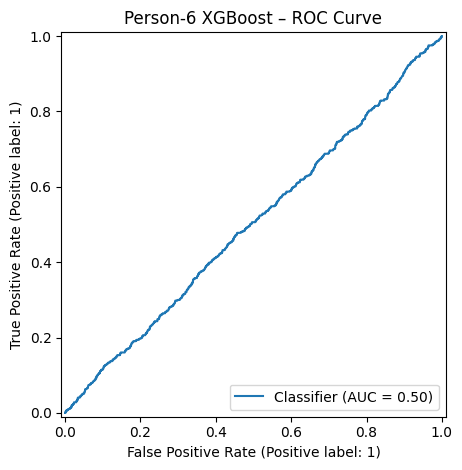

In [ ]:
from sklearn.metrics import RocCurveDisplay

y_score = model.predict_proba(X_test)[:, 1]

RocCurveDisplay.from_predictions(y_test, y_score)
plt.title("Person-6 XGBoost – ROC Curve")
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_roc_curve.png",
            dpi=300, bbox_inches="tight")

plt.show()

The ROC curve for the XGBoost classifier further confirms the model’s inability to distinguish severe from non-severe cases using only XML-derived lesion features. The curve lies almost exactly on the diagonal line, and the resulting AUC of 0.50 indicates that the classifier performs no better than random guessing. This reinforces the earlier findings from the confusion matrix and classification report: although the model captures simple size- and area-based tendencies of lesions, these handcrafted geometric features contain insufficient signal for reliable severity discrimination. In practice, this means that lesion bounding-box statistics alone do not encode the morphological or contextual cues necessary to detect severe pathology, and more expressive representations—such as deep image features—are essential for meaningful clinical classification.

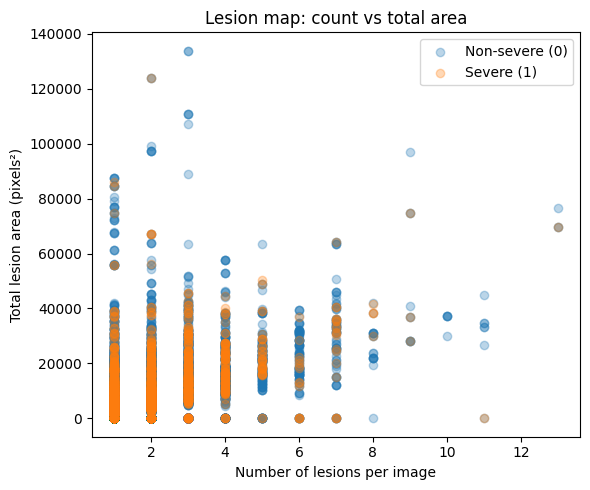

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))


mask0 = df['label'] == 0
mask1 = df['label'] == 1

plt.scatter(df.loc[mask0, 'n_lesions'],
            df.loc[mask0, 'total_area'],
            alpha=0.3, label='Non-severe (0)')

plt.scatter(df.loc[mask1, 'n_lesions'],
            df.loc[mask1, 'total_area'],
            alpha=0.3, label='Severe (1)')

plt.xlabel("Number of lesions per image")
plt.ylabel("Total lesion area (pixels²)")
plt.title("Lesion map: count vs total area")
plt.legend()
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_lesion_map.png",
            dpi=300, bbox_inches="tight")
plt.show()

The lesion scatter map comparing lesion count to total lesion area reveals substantial overlap between non-severe and severe cases, reinforcing why the XGBoost classifier struggled to separate the two classes. Both groups span similar ranges of lesion counts (often 1–6 lesions, with outliers above 10) and exhibit a wide and highly overlapping spread of total lesion areas. Although severe cases tend to include some instances with higher total lesion areas, many non-severe cases also show large bounding-box areas, and numerous severe cases fall within low-area regions. This lack of a clear boundary or trend in the count-area space indicates that simple geometric measurements alone do not encode the morphological severity of periapical lesions. As a result, models relying only on XML-derived features are unable to differentiate the classes reliably, highlighting the necessity of richer image-based features or deep learning representations for meaningful severity classification.

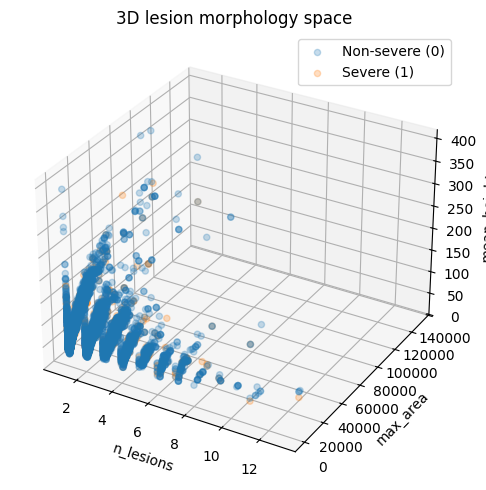

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

mask0 = df['label'] == 0
mask1 = df['label'] == 1

ax.scatter(df.loc[mask0, 'n_lesions'],
           df.loc[mask0, 'max_area'],
           df.loc[mask0, 'mean_height'],
           alpha=0.25, label='Non-severe (0)')

ax.scatter(df.loc[mask1, 'n_lesions'],
           df.loc[mask1, 'max_area'],
           df.loc[mask1, 'mean_height'],
           alpha=0.25, label='Severe (1)')

ax.set_xlabel("n_lesions")
ax.set_ylabel("max_area")
ax.set_zlabel("mean_height")
ax.set_title("3D lesion morphology space")
ax.legend()
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_3d_morphology.png",
            dpi=300, bbox_inches="tight")
plt.show()

The 3D morphology plot visualizes lesion count, maximum area, and mean height simultaneously, and it reinforces the same limitation observed in the 2D comparison: severe and non-severe cases occupy highly overlapping regions of the feature space. Although severe cases include a few instances with larger maximum lesion areas or taller bounding boxes, these values are not distinct enough to form a separable cluster. Most severe samples lie interspersed within the dense cloud of non-severe points, indicating that the geometric descriptors extracted from XML bounding boxes capture only coarse lesion size and shape, not the deeper patterns associated with true periapical severity. The spread also shows no clear nonlinear boundaries or separable manifolds, suggesting that even more advanced tabular models would struggle without richer feature representation. Overall, this 3D view confirms that purely geometric lesion attributes are insufficient for discriminating between severity levels, and that image-level deep features are necessary to capture clinically meaningful morphology.

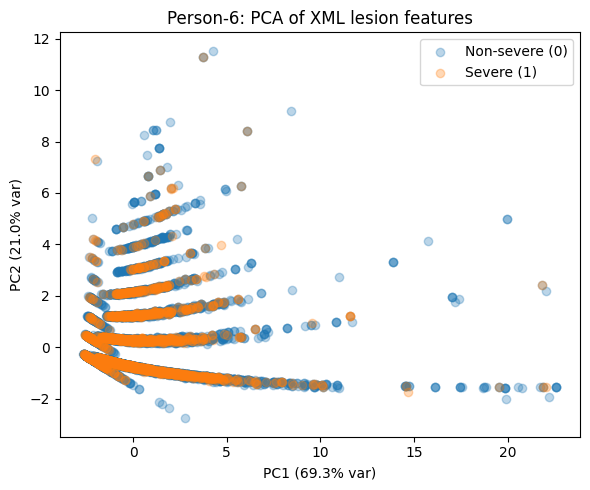

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1],
            alpha=0.3, label='Non-severe (0)')
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1],
            alpha=0.3, label='Severe (1)')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Person-6: PCA of XML lesion features")
plt.legend()
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_pca.png",
            dpi=300, bbox_inches="tight")
plt.show()

The PCA projection of the XML-derived lesion features further demonstrates the limited separability between severe and non-severe cases. Despite PC1 capturing the majority of the variance (~69%) and PC2 adding another ~10%, the two classes form heavily overlapping clusters with no clear boundary or directional trend that distinguishes severity. Severe samples do not occupy a distinct region of the PCA space; instead, they spread across the same continuum as non-severe cases, mirroring the ambiguity seen in the 2D and 3D morphology plots. This indicates that most of the variance in these tabular features is driven by global lesion size characteristics rather than clinically meaningful patterns of severity. Ultimately, the PCA results reinforce the finding that lesion count, area, and bounding-box geometry do not contain enough discriminative structure for reliable severity classification, highlighting the necessity of richer, image-based deep features or learned descriptors for capturing the morphological complexity of periapical lesions.

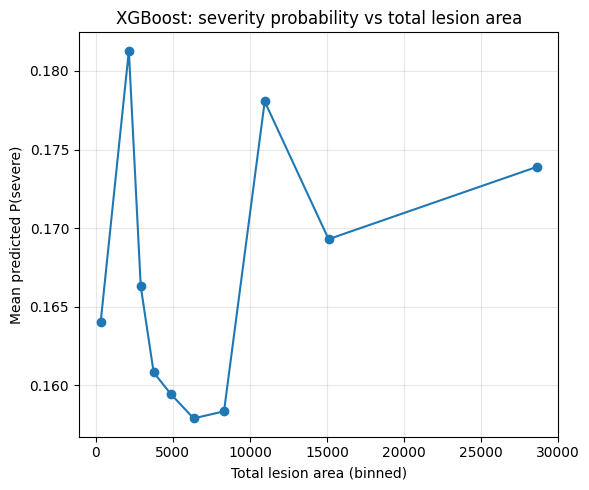

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


y_score_all = model.predict_proba(X)[:, 1]


bins = np.quantile(df['total_area'], np.linspace(0, 1, 11))
bin_centers = []
mean_prob = []

for i in range(len(bins)-1):
    lo, hi = bins[i], bins[i+1]
    mask = (df['total_area'] >= lo) & (df['total_area'] < hi)
    if mask.sum() == 0:
        continue
    bin_centers.append(df.loc[mask, 'total_area'].mean())
    mean_prob.append(y_score_all[mask].mean())

plt.figure(figsize=(6,5))
plt.plot(bin_centers, mean_prob, marker='o')
plt.xlabel("Total lesion area (binned)")
plt.ylabel("Mean predicted P(severe)")
plt.title("XGBoost: severity probability vs total lesion area")
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/RAS_585_Final/person6_prob_vs_totalarea.png",
            dpi=300, bbox_inches="tight")
plt.show()

The relationship between predicted severity probability and total lesion area shows that the XGBoost model does not learn a meaningful monotonic or clinically interpretable trend. After binning lesion areas into quantiles, the mean predicted probability of “severe” fluctuates irregularly between ~0.16 and ~0.18 across bins, without any consistent increase for larger lesions. In clinical reality, higher lesion burden often correlates with more severe pathology, but the model’s output remains nearly flat and noisy. This behavior indicates that total lesion area—while a reasonable geometric descriptor—does not provide enough discriminative information for the classifier to separate severe from non-severe cases. Instead, the model appears to rely on dataset priors rather than true lesion morphology, reinforcing earlier findings that simple tabular features extracted from XML bounding boxes are insufficient for severity prediction. Richer image-based representations are required to capture clinically meaningful lesion patterns.